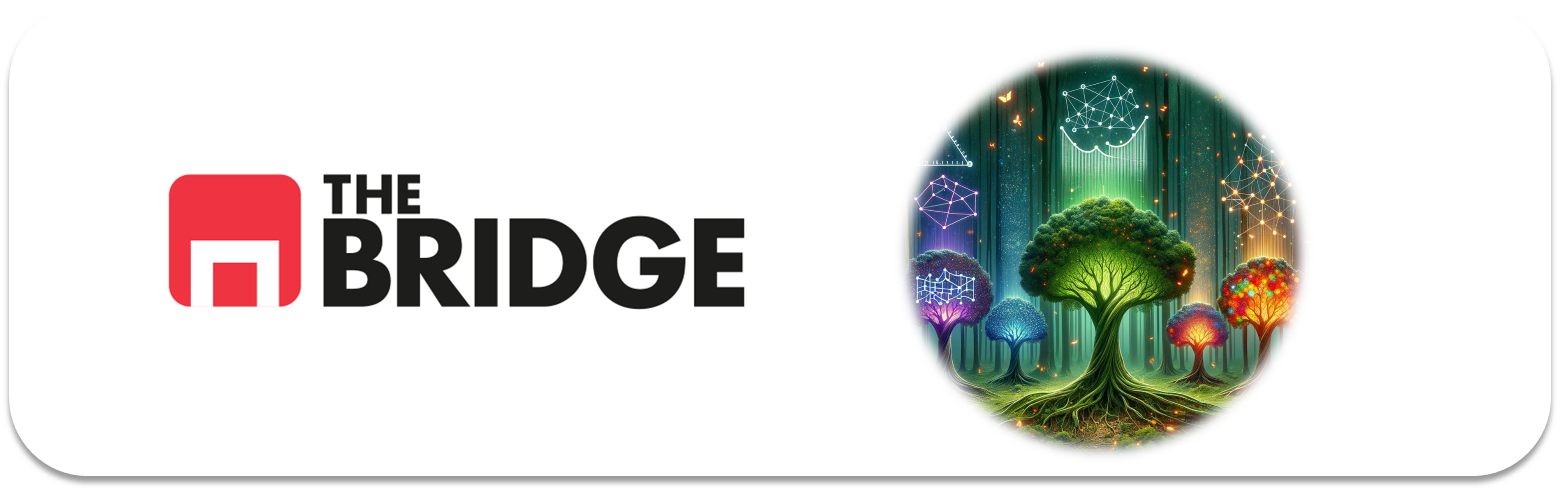

## PRACTICA OBLIGATORIA: **Arboles de Decisión y Ajuste de hiperparámetros**

* La práctica obligatoria de esta unidad consiste en encontrar el mejor modelo para resolver un problema de predicción de si los destinatarios de una campaña de marketing adquirirán un producto concreto. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler

import sys
sys.path.append('/Users/aliciamarzoa/Will/the_bridge/personal_projects/stats_help')
import dstoolbox as tlbx

import bootcampviztools as booty

### Descripción

En el directorio data encontrarás un dataset que contiene datos relacionados con campañas de marketing directo de una institución bancaria portuguesa (es el dataset "Bank Marketing" de la UCI Machine Learning Repository). Los datos se recopilaron de campañas de marketing telefónico, donde el objetivo principal era predecir si el cliente se suscribiría a un depósito a plazo.

La práctica consiste en completar el proceso de creación de un modelo basado en árboles de decisión que permita predecir si un cliente (dadas unas características similares a las del dataset) "comprará" el depósito a plazo. Sigue los pasos necesarios de un proceso de ML para crear el modelo, optimizar sus hiperparámetros, comparar los resultados de esa optimización con una regresión logística (sin optimizar, con sus hiperparámetros por defecto) y finalmente evaluarlo contra test y hacer una pequeña valoración del resultado obtenido.

Tendrás que hacer la limpieza, split, minieda, selección, tratamiento, primeros entrenamientos, optimización, comparación y evaluación según tu mejor criterio. Eso sí, es obligatorio:
- Identificar el target y analizar su distribución
- Realizar una optimización de hiperparámetros, escogiendo un grid medianemante razonado
- Comparar con el modelo baseline
- Evaluar contra test

1. Inspect missings carefully.
    - might not be null values but could be set as 'unknown'
    - need to check if they are genuine unknowns or if unknwon is a category
    - implication is what to do with these.
        - Are they np.nans?
        - Impute with mode?

2. Don't be too harsh when doing bivariate of categoricas with target
    - if there is some difference in frequency distributions keep the variable.
    - variables with an almost identical distribution don't bother with them as they dont really provide any other information.

3. sns.pairplot() diagonal is like doing the booty.plot_grouped_historgram(train_set, cat_col=target, num_col = col, group_size=)
    - Much easier to see what might be more intersting and useful to include in model
    - features_num = ['age','day','duration','pdays']
    - features_num2 = ['previous']
    - cat_features
        - to change yes/no to boolean
            - train_set['housing'] = train_set['housing'] == 'yes'
        - OneHot:
            - binary coding for each category in a variable
            - pd.dummies same as onehotencoder
                - drop_first=True is a get dummies

4. Try to get distributions of numeric variables as symetrical as possible.
    - dont worry too much about a strictly 'normal distribution'
        - log transform
        - add something to get values above 0
        - StandardScaler() the numeric features
    - I was thinking along the right lines with pdays etc in considering changing to a binary contacted before/never contacted
    - allows an analysis of those that have been contacted and how many days ago the contact was in function of target variable
        - grouped_histogram of ['new_binary_cat'] == 1


AYUDA: La dirección del banco nos proporciona estas notas (en inglés):

 
   **bank client data:**  
   1 - age (numeric)  
   2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
                                       "blue-collar","self-employed","retired","technician","services")   
   3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)  
   4 - education (categorical: "unknown","secondary","primary","tertiary")  
   5 - default: has credit in default? (binary: "yes","no")  
   6 - balance: average yearly balance, in euros (numeric)   
   7 - housing: has housing loan? (binary: "yes","no")  
   8 - loan: has personal loan? (binary: "yes","no")   

   **related with the last contact of the current campaign:**  
   9 - contact: contact communication type (categorical: "unknown","telephone","cellular")   
  10 - day: last contact day of the month (numeric)  
  11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")  
  12 - duration: last contact duration, in seconds (numeric)    

   **other attributes:**  
  13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)  
  14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)  
  15 - previous: number of contacts performed before this campaign and for this client (numeric)  
  16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

---
---
# 1. Get Data

In [2]:
marketing_df = pd.read_csv('./data/bank-full.csv', sep=';')
marketing_df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


In [3]:
tlbx.describe_df(marketing_df, print_dups=True, entries=True, transpose=False)

Total entries in DataFrame:  45211
Total duplicated entries: 0


,DATA_TYPE,NUM_MISSING,MISSINGS (%),UNIQUE_VALUES,CARDIN (%)
age,int64,0,0.0,77,0.17
job,object,0,0.0,12,0.03
marital,object,0,0.0,3,0.01
education,object,0,0.0,4,0.01
default,object,0,0.0,2,0.00
balance,int64,0,0.0,7168,15.85
housing,object,0,0.0,2,0.00
loan,object,0,0.0,2,0.00
contact,object,0,0.0,3,0.01
day,int64,0,0.0,31,0.07


In [4]:
tlbx.tipify_variables(marketing_df, categoric_threshold=15, continuous_threshold=50)

Based on a categoric threshold of: 15
and a continuous threshold of: 50%


,nombre_variable,tipo_sugerido
0,age,Numerical Discrete
1,job,Categorical
2,marital,Categorical
3,education,Categorical
4,default,Binary
5,balance,Numerical Discrete
6,housing,Binary
7,loan,Binary
8,contact,Categorical
9,day,Numerical Discrete


In [5]:
target = 'y'
features = [col for col in marketing_df.columns if col != target]

---
---
# 2. Split Data
- For now just going to split into 'train_set' and 'test_set'
- Seems easier for EDA and treating features

In [6]:
train_set, test_set = train_test_split(marketing_df, test_size=0.2, stratify=marketing_df[target], random_state=42)

In [7]:
train_set.y

24001     no
43409    yes
20669    yes
18810     no
23130     no
        ... 
17958     no
15941     no
16952     no
34781     no
44229    yes
Name: y, Length: 36168, dtype: object

---
---
# 3. Mini-EDA

In [8]:
# Value counts of the target
train_set[target].value_counts(True)

no     0.883018
yes    0.116982
Name: y, dtype: float64

- Unbalanced!
- Does this matter for decision trees?

---
### Numerical Features

In [9]:
# Quick description of numeric features in DataFrame
train_set.describe()

,age,balance,day,duration,campaign,pdays,previous
count,36168.000000,36168.00000,36168.000000,36168.000000,36168.000000,36168.000000,36168.000000
mean,40.892999,1365.49342,15.817961,258.506940,2.763935,40.157238,0.581730
std,10.627075,3068.54350,8.331980,259.142445,3.104161,100.162614,2.408766
min,18.000000,-8019.00000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,74.00000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,451.00000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1430.25000,21.000000,318.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.00000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [10]:
# Get numeric features from describe()
num_features = train_set.describe().columns.to_list()
num_features

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

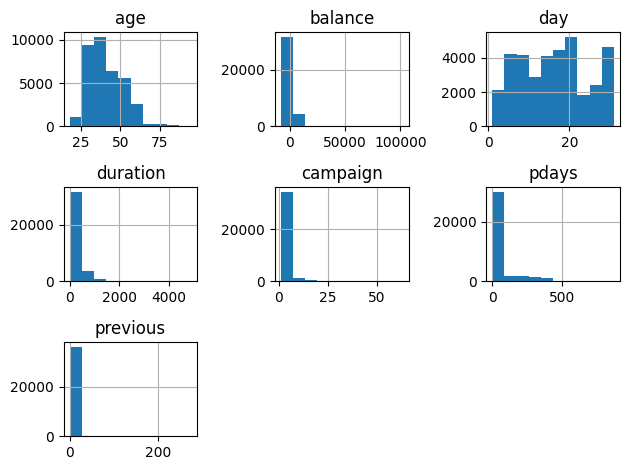

In [11]:
# Histograms of numeric features
train_set.hist()
plt.tight_layout()

- distributions are all very a bit strange.
- althought not necessary for decision trees or logistic regression, will try to get these distributions somewhat closer to 'normal'

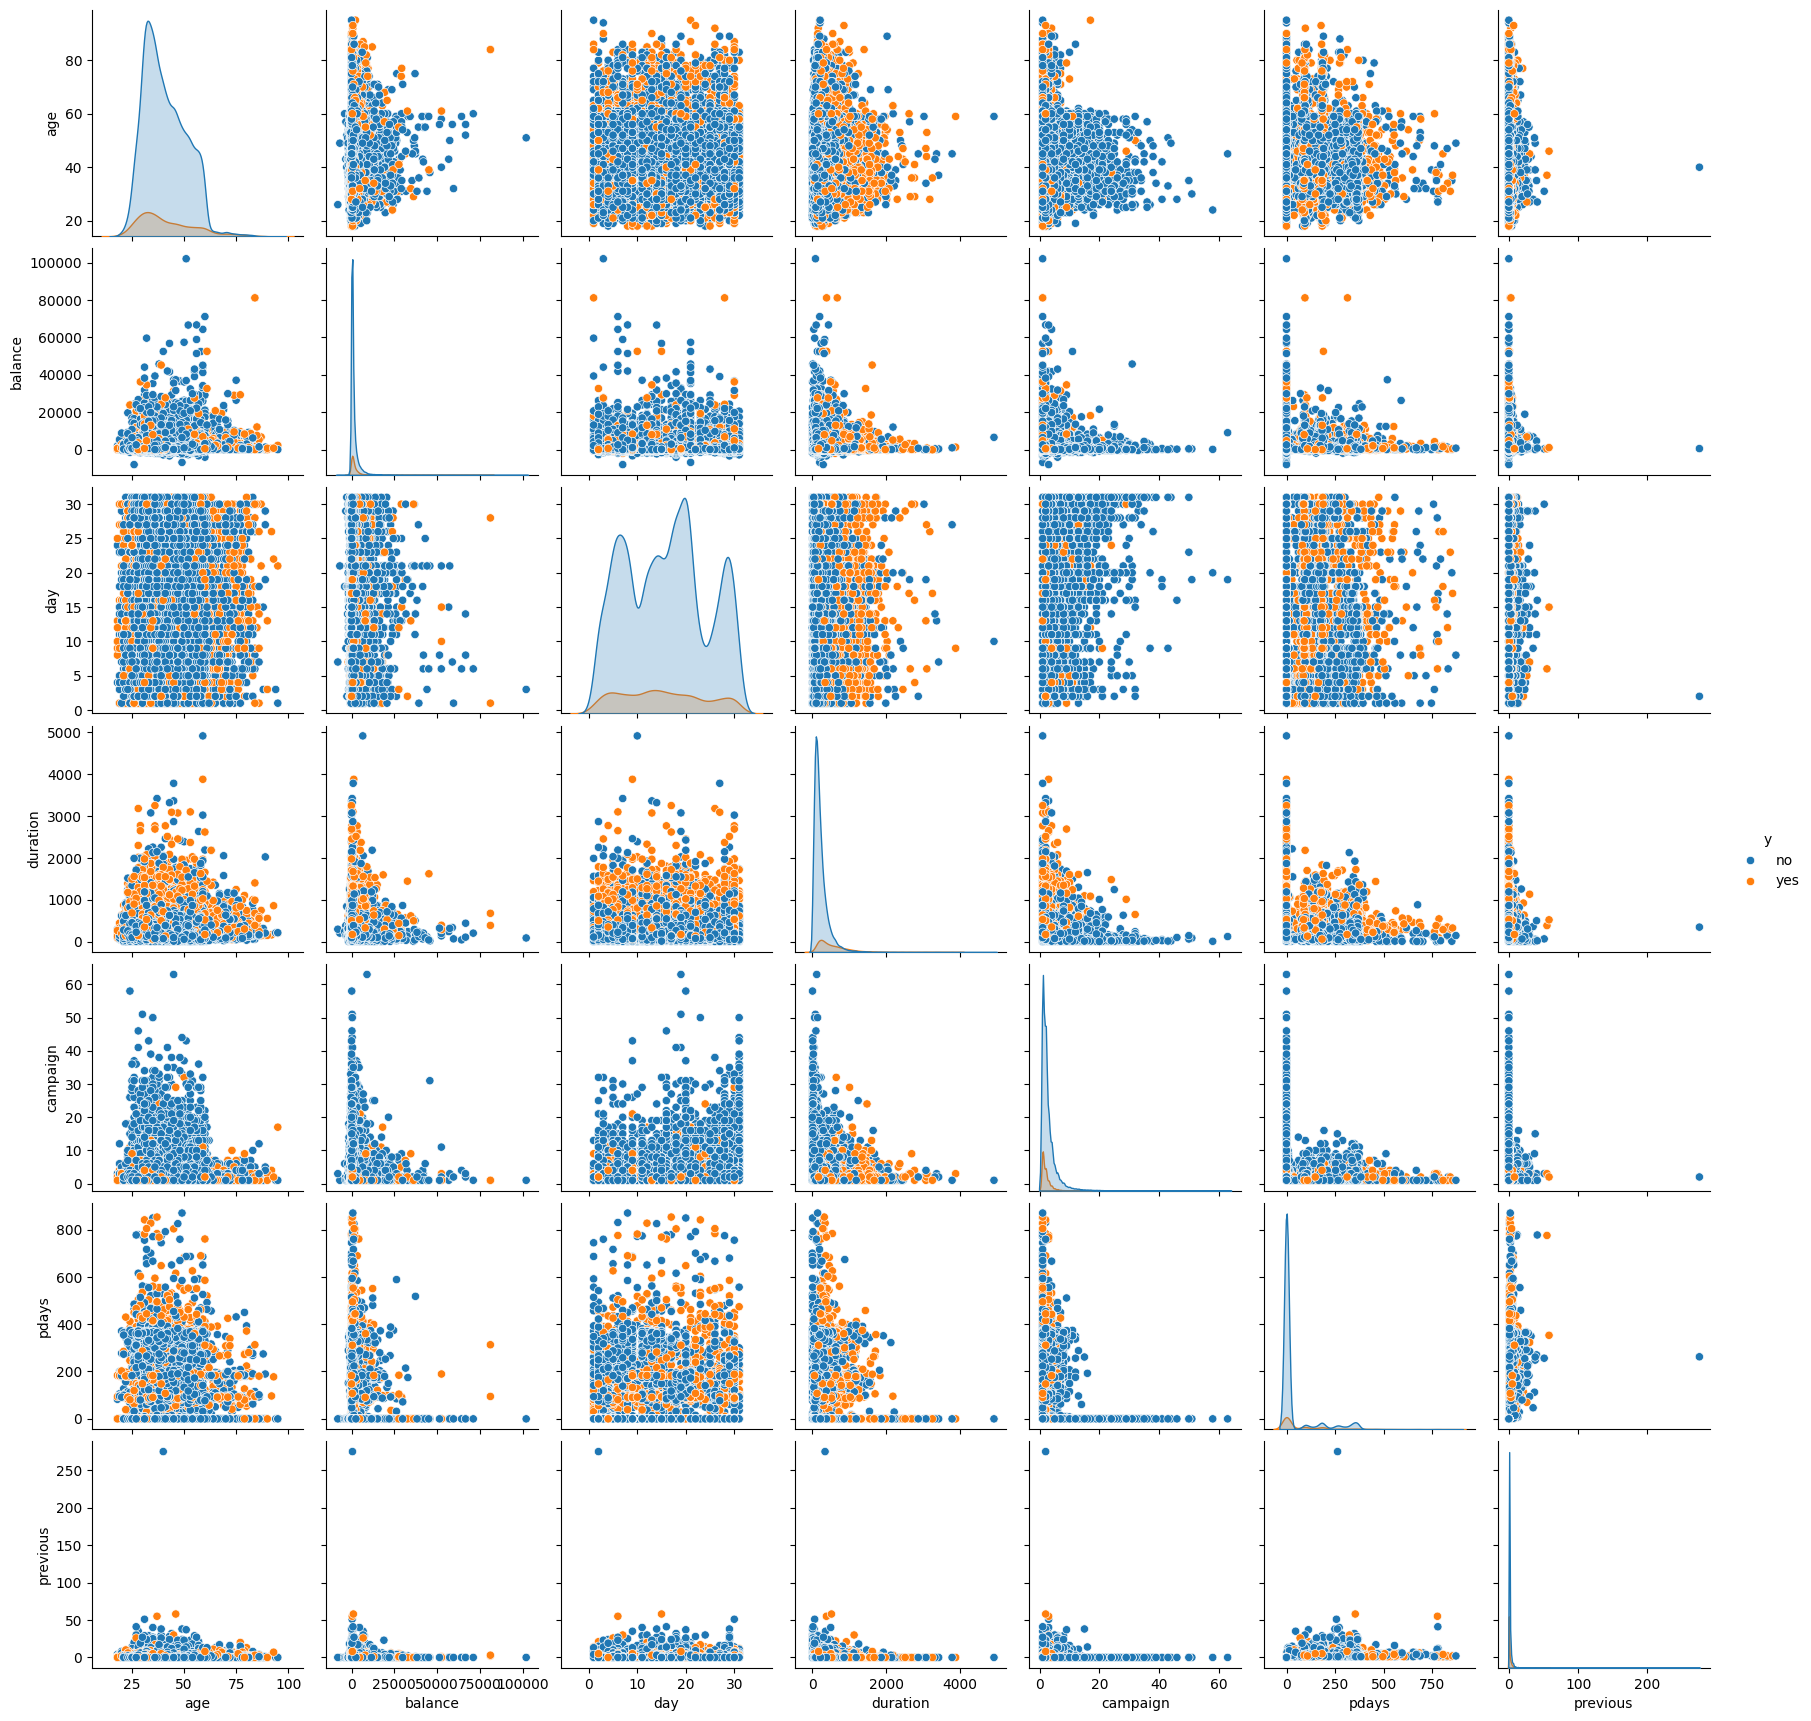

In [12]:
# Pair Plots of numeric features and target
sns.pairplot(train_set[num_features + [target]], hue=target)

- Weak correlations between numeric features
- Most clustering of each class in pair plots with duration
- Density plots don't show much feature separation by target which is not so helpful for selecting specific features.
- Starting to see some separation of distributions in campaign that could be a sign of class separation

In [13]:
best_features = ['duration','campaign']

---
### Correlations beetween numeric features

<Axes: >

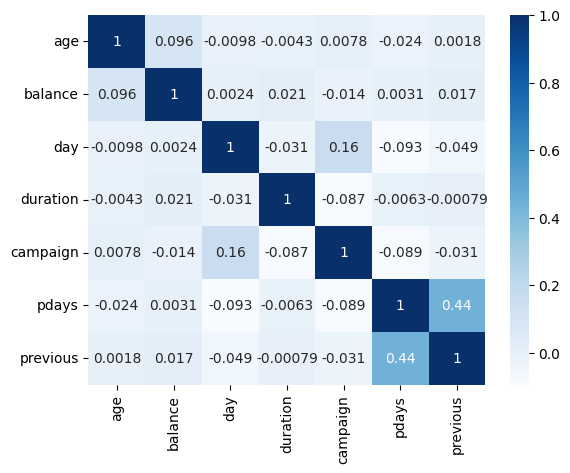

In [14]:
corr_mat = train_set[num_features].corr()
sns.heatmap(corr_mat, annot=True, cmap='Blues')

- From what i have understood, decision trees can deal with colinearity fairly well
- in logistic regression models this needs to be checked and fixed. 
- very weak correlations between all of these features except pdays and previous.
    - Check relationship between these two features and target.

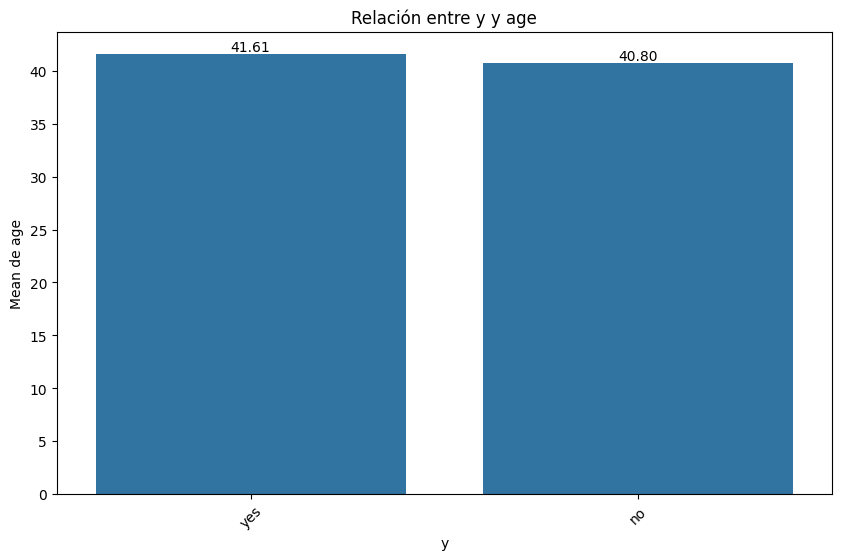

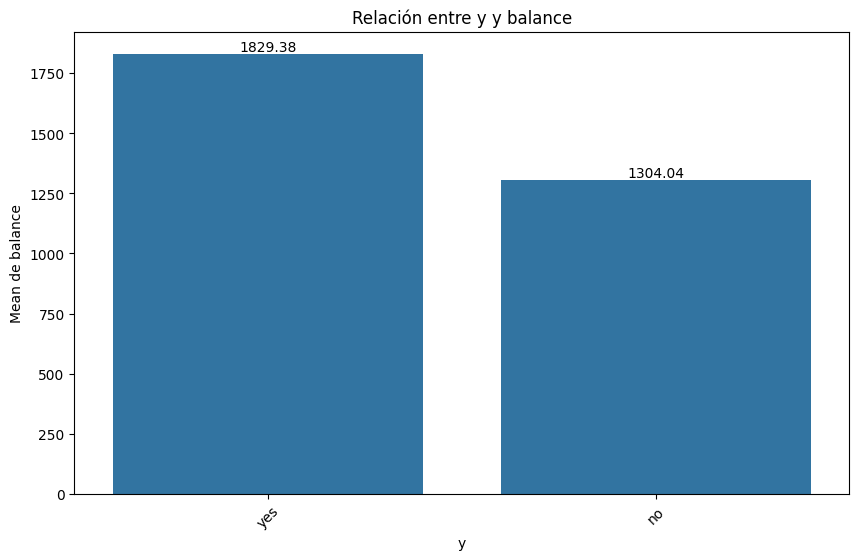

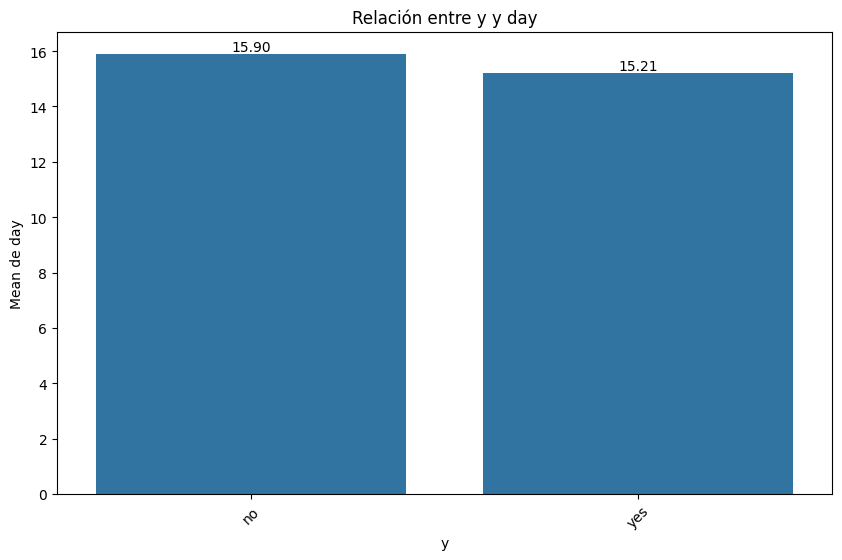

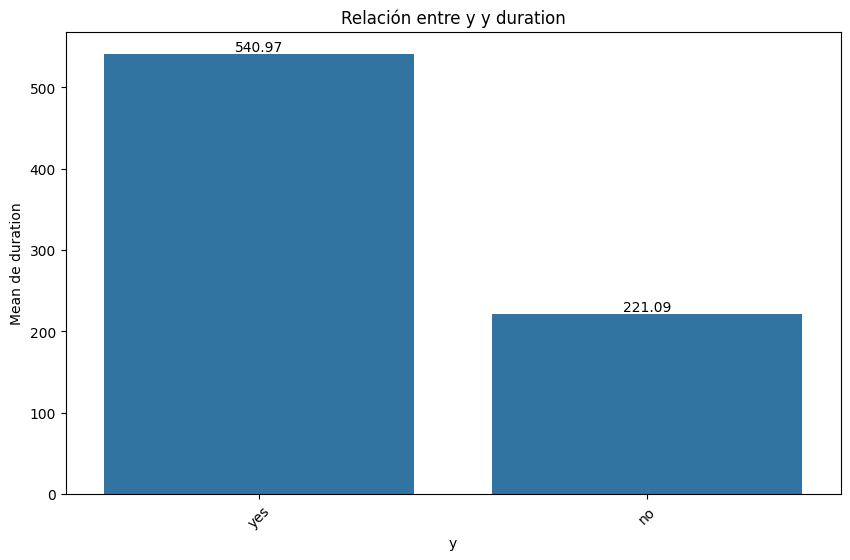

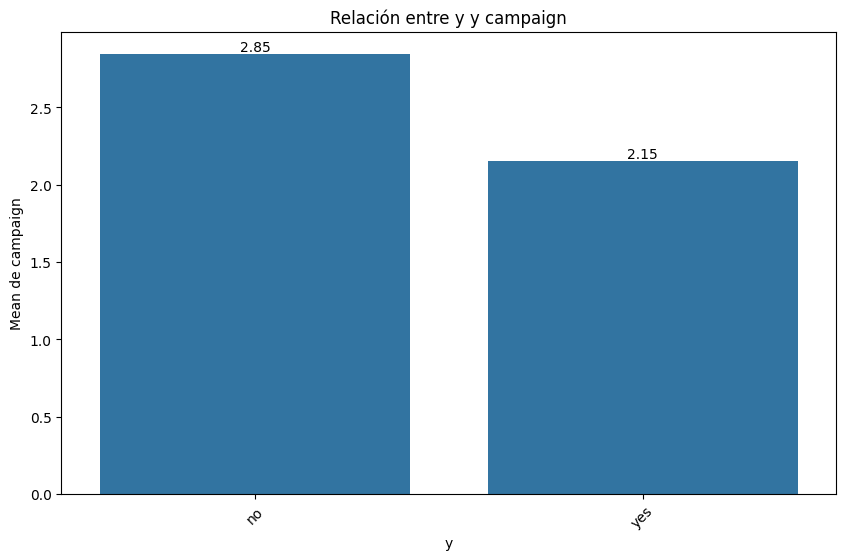

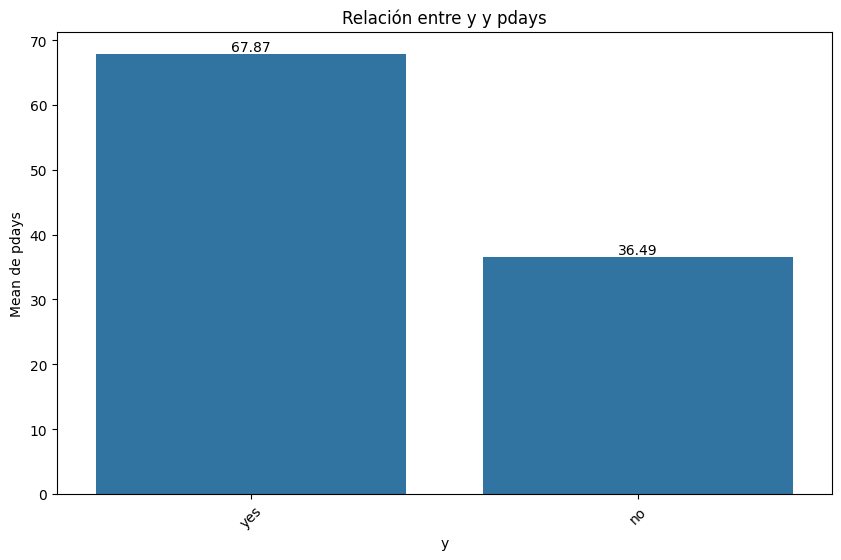

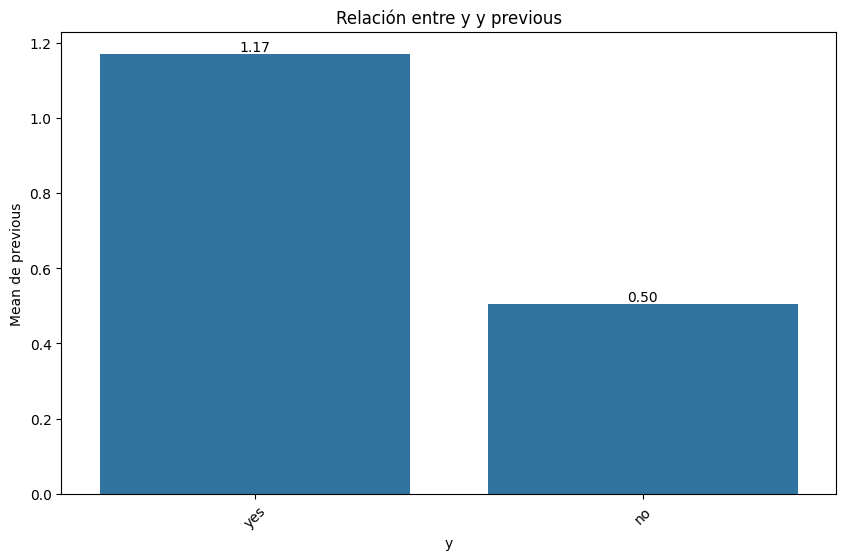

In [15]:
# Carry out full bivariate between target and all numeric variables with special attention on previous and pdays
for col in num_features:
    booty.plot_categorical_numerical_relationship(train_set, target, col, show_values=True)

- almost no separation between:
    - age and target classes
    - day and target classes

In [16]:
interesting = ['previous','balance']
for feat in interesting:
    best_features.append(feat)

---
### Categorical Features

In [17]:
# Create a cat_features list
cat_features = [col for col in train_set if col not in num_features and col not in target]
cat_features

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome']

In [18]:
# Print value counts for each class in categorical features
for feature in cat_features:
    print(f"Feature: {feature}")
    print(train_set[feature].value_counts())
    print()

Feature: job
blue-collar      7830
management       7511
technician       6068
admin.           4141
services         3348
retired          1812
self-employed    1243
entrepreneur     1186
unemployed       1024
housemaid        1013
student           758
unknown           234
Name: job, dtype: int64

Feature: marital
married     21771
single      10227
divorced     4170
Name: marital, dtype: int64

Feature: education
secondary    18561
tertiary     10594
primary       5531
unknown       1482
Name: education, dtype: int64

Feature: default
no     35521
yes      647
Name: default, dtype: int64

Feature: housing
yes    20182
no     15986
Name: housing, dtype: int64

Feature: loan
no     30355
yes     5813
Name: loan, dtype: int64

Feature: contact
cellular     23465
unknown      10386
telephone     2317
Name: contact, dtype: int64

Feature: month
may    11062
jul     5537
aug     4986
jun     4237
nov     3143
apr     2394
feb     2078
jan     1119
oct      592
sep      451
mar      391
d

In [19]:
# Convert to numeric binary from 'yes'/'no'
num_binary = ['default','housing','loan']

# For one hot encoding
one_hotters = ['job','marital','education','contact','month','poutcome']

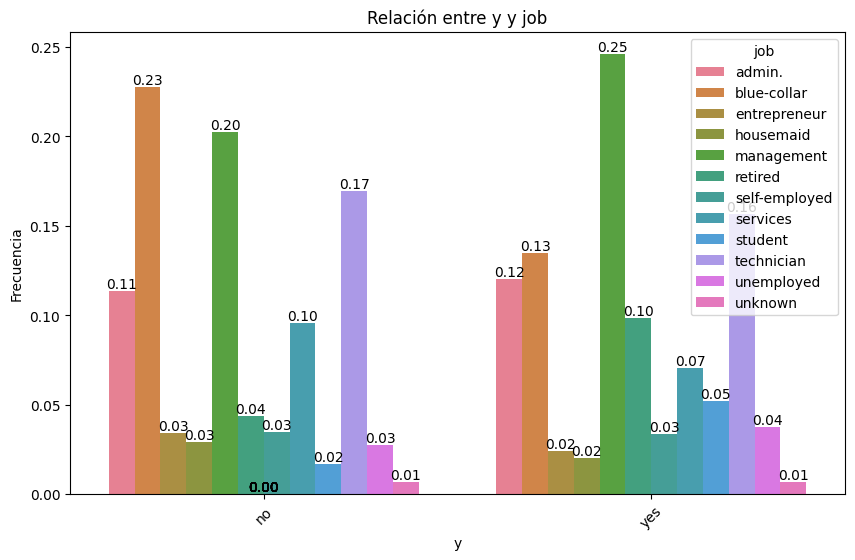

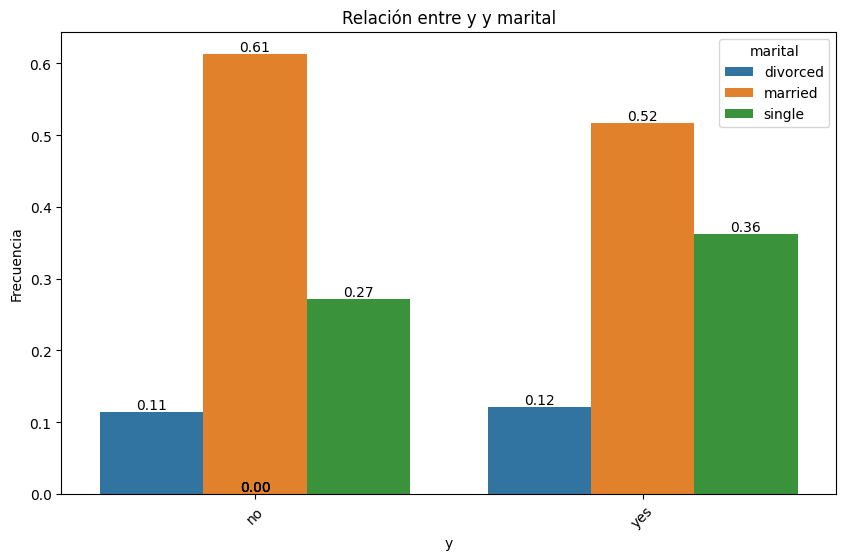

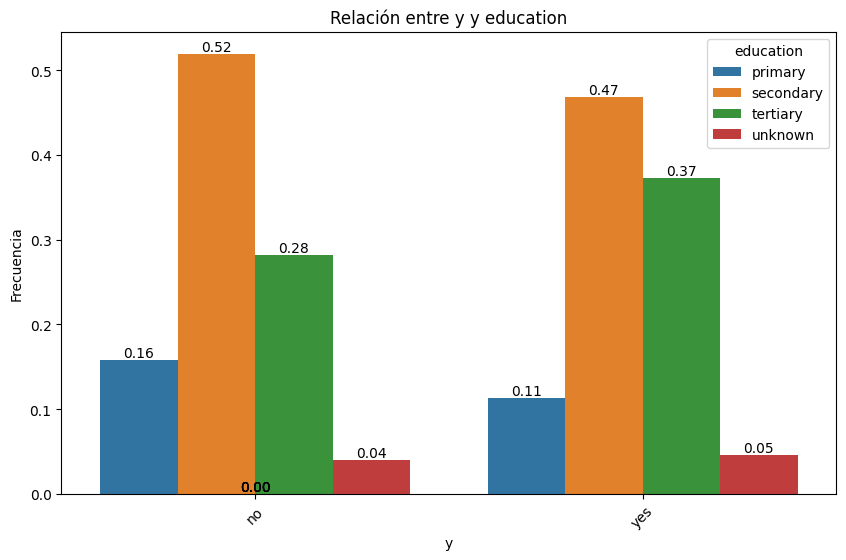

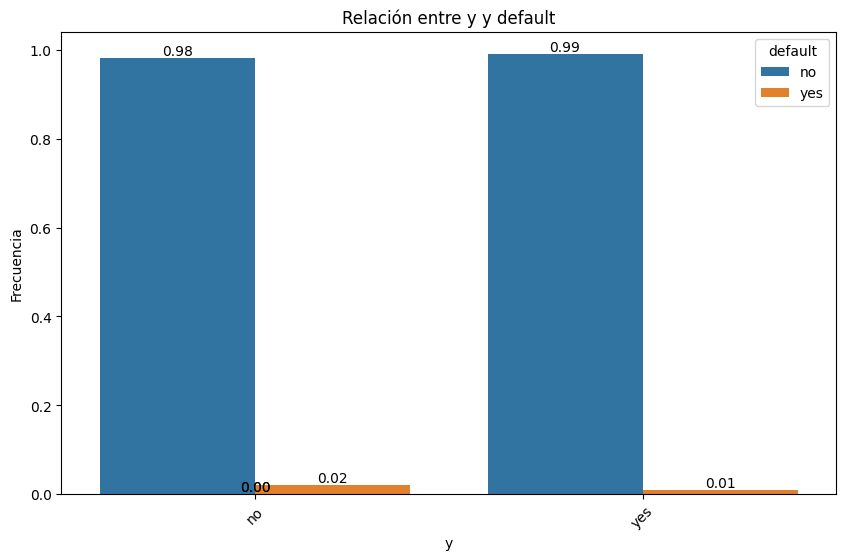

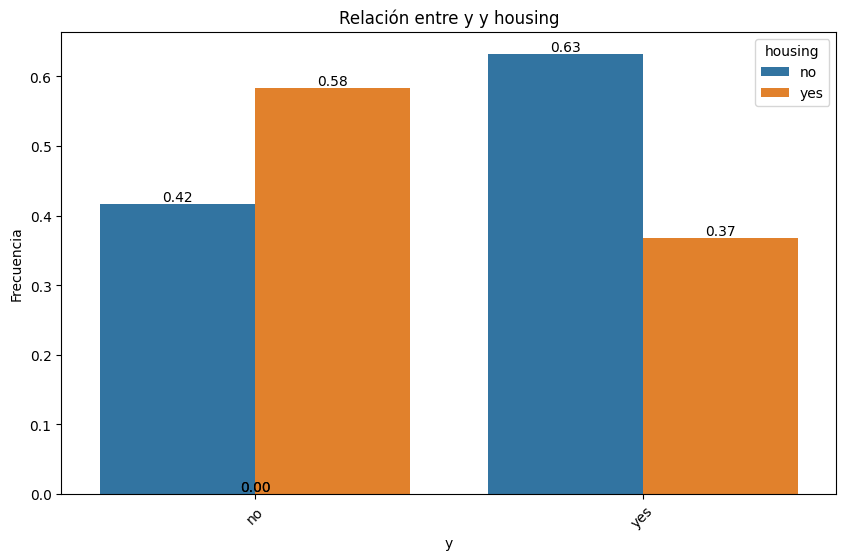

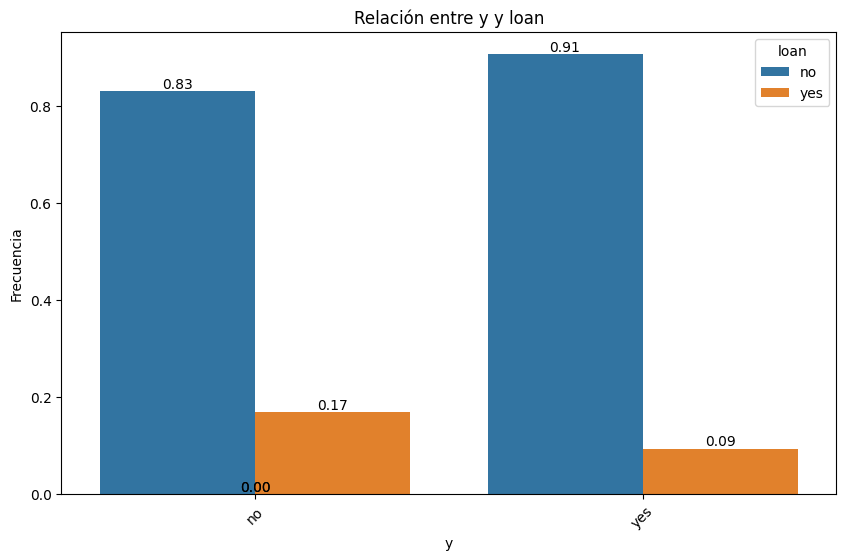

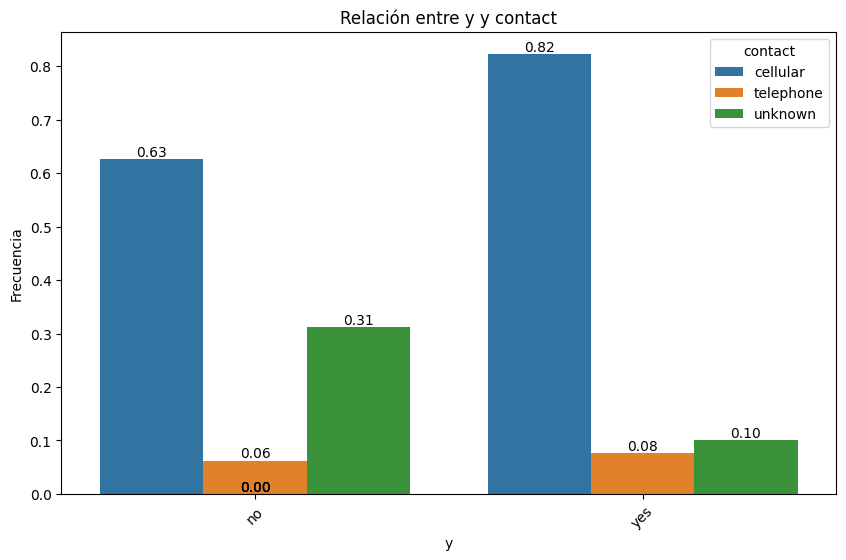

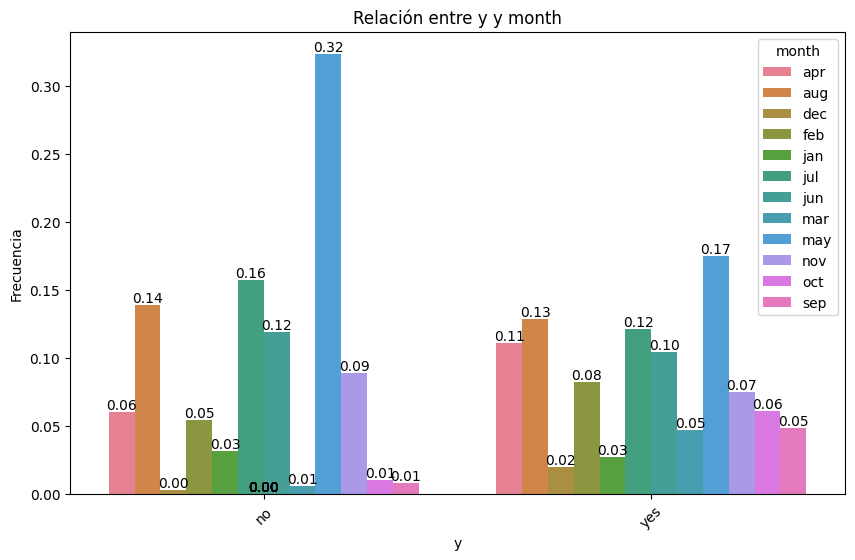

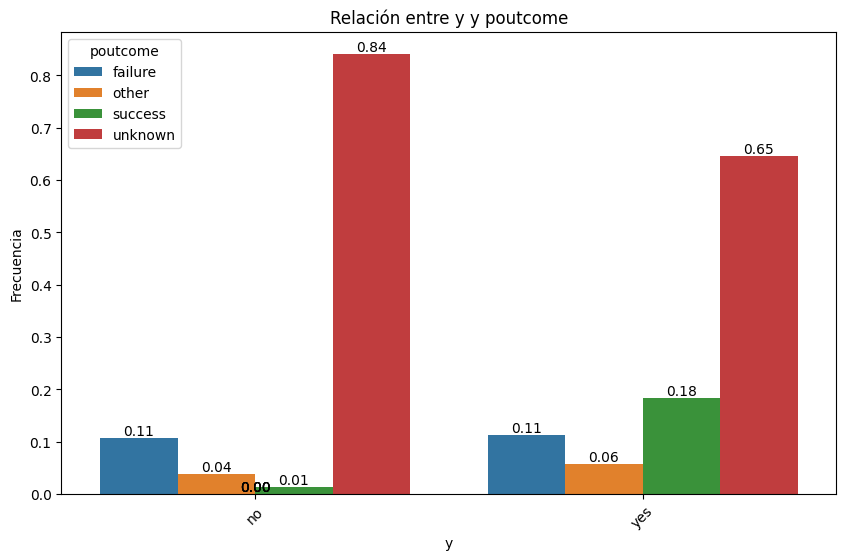

In [20]:
# Countplots for each categoric feature by target feature
for feature in cat_features:
    booty.plot_categorical_relationship_fin(train_set, target, feature, show_values=True, relative_freq=True)

- Distribution between target classes is very similar for each categoric feature.
- percentage of each category changes but the distributions remain more or less the same.
- EXCEPTIONS: housing and poutcome
    - There are distinct distribution changes between the categories of these features and the target feature categories.

In [21]:
interesting = 'housing','poutcome'
for feat in interesting:
    best_features.append(feat)

---
---
# 4. Feature Selection

In [22]:
num_features

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

In [23]:
cat_features

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome']

In [24]:
# Features that showed most interesting relationships
best_features

['duration', 'campaign', 'previous', 'balance', 'housing', 'poutcome']

---
---
# 5. Treating data

In [51]:
# Brought this down in case of a coding-cock-up and needing to reset
train_set, test_set = train_test_split(marketing_df, test_size=0.2, stratify=marketing_df[target], random_state=42)

---
### Categoric Features

In [52]:
# Target to binary 1 = yes
train_set[target] = train_set[target].apply(lambda x: 1 if x=='yes' else 0)
train_set[target] = train_set[target].astype(int)
test_set[target] = test_set[target].apply(lambda x: 1 if x=='yes' else 0)
test_set[target] = test_set[target].astype(int)

In [53]:
# num_binary ['default', 'housing', 'loan'] to binary, 1 = yes
for col in num_binary:
    train_set[col] = train_set[col].apply(lambda x: 1 if x == 'yes' else 0).astype(int)
    test_set[col] = test_set[col].apply(lambda x: 1 if x == 'yes' else 0).astype(int)


In [54]:
best_features

['duration', 'campaign', 'previous', 'balance', 'housing', 'poutcome']

In [55]:
# Define X and y for train and test sets
X_train_sel = train_set[best_features].copy()
y_train = train_set[target].copy()

X_test_sel = test_set[best_features].copy()
y_test = test_set[target].copy()

In [56]:
# define columns for one hot encoding that are in the feature selection i want to use
best_one_hotters = [col for col in one_hotters if col in best_features]

# One hot encode fetures
X_train_sel = pd.get_dummies(X_train_sel, columns = best_one_hotters)
X_test_sel = pd.get_dummies(X_test_sel, columns = best_one_hotters)

---
### Numeric Features
- need to do some transformations for logistic regression but unsure what to do and how to proceed

In [57]:
num_features_sel = [col for col in num_features if col in best_features]

In [58]:
scaler = StandardScaler()
X_train_sel[num_features_sel] = scaler.fit_transform(X_train_sel[num_features_sel])
X_test_sel[num_features_sel] = scaler.transform(X_test_sel[num_features_sel])

---
---
# 6. Model Selection and Training

---
### Decision Tree Classifier

In [59]:
clf = DecisionTreeClassifier()
clf.fit(X_train_sel, y_train)

DecisionTreeClassifier()

In [60]:
y_preds_train = clf.predict(X_train_sel)
y_preds_test = clf.predict(X_test_sel)

---
### Logistic Regression

In [61]:
lr = LogisticRegression()
lr.fit(X_train_sel, y_train)

LogisticRegression()

In [62]:
y_preds_train_lr = lr.predict(X_train_sel)
y_preds_test_lr = lr.predict(X_test_sel)

---
---
# 7. Model Evaluation

### Decision Tree Classifier

In [63]:
print(classification_report(y_train, y_preds_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     31937
           1       1.00      0.99      1.00      4231

    accuracy                           1.00     36168
   macro avg       1.00      1.00      1.00     36168
weighted avg       1.00      1.00      1.00     36168



In [64]:
print(classification_report(y_test, y_preds_test))

              precision    recall  f1-score   support

           0       0.92      0.91      0.91      7985
           1       0.37      0.39      0.38      1058

    accuracy                           0.85      9043
   macro avg       0.64      0.65      0.65      9043
weighted avg       0.85      0.85      0.85      9043



---

### Logistic Regression

In [65]:
print(classification_report(y_train, y_preds_train_lr))

              precision    recall  f1-score   support

           0       0.91      0.98      0.94     31937
           1       0.64      0.31      0.42      4231

    accuracy                           0.90     36168
   macro avg       0.78      0.64      0.68     36168
weighted avg       0.88      0.90      0.88     36168



In [66]:
print(classification_report(y_test, y_preds_test_lr))

              precision    recall  f1-score   support

           0       0.91      0.98      0.94      7985
           1       0.64      0.29      0.40      1058

    accuracy                           0.90      9043
   macro avg       0.78      0.64      0.67      9043
weighted avg       0.88      0.90      0.88      9043



---
---
# 8. Optimization

In [78]:
lr_params = {'C': [0.01, 0.1, 1, 10],
             'solver': ['libliner','lbfgs'],
             'max_iter': [5000,10000,15000,20000]
             }

tree_clf_params = {'max_depth': [None,2,5,10,20,50],
                   'min_samples_split': [2,5,10,20],
                   'min_samples_leaf': [1,2,5,10]
                   }

---
### RandomizedSearch

In [79]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [80]:
# DecisionTreeClassifier
clf_rndSearch = RandomizedSearchCV(clf, tree_clf_params, n_iter=20, cv=5, scoring='accuracy', random_state=42)
clf_rndSearch.fit(X_train_sel, y_train)

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_iter=20,
                   param_distributions={'max_depth': [None, 2, 5, 10, 20, 50],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 20]},
                   random_state=42, scoring='accuracy')

In [82]:
# LogisticRegression
lr_randSearch = RandomizedSearchCV(lr, lr_params, n_iter=25, cv=5, scoring='accuracy', random_state=42)
lr_randSearch.fit(X_train_sel, y_train)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
55 fits failed out of a total of 125.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
55 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/

RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=25,
                   param_distributions={'C': [0.01, 0.1, 1, 10],
                                        'max_iter': [5000, 10000, 15000, 20000],
                                        'solver': ['libliner', 'lbfgs']},
                   random_state=42, scoring='accuracy')

---
### Comparison and Evaluation

In [86]:
# DecisionTreeClassifier
print("DecisionTreeClassifier RandomizedSearch Report:")
print(f"Best Params: {clf_rndSearch.best_params_}")
print(f"Best Score: {clf_rndSearch.best_score_}")
print(f"Best Estimator Score: {clf_rndSearch.best_estimator_.score(X_test_sel, y_test)}")
print()
# Logistic Regression
print("LogisticRegression RandomizedSearch Report:")
print(f"Best Params: {lr_randSearch.best_params_}")
print(f"Best Score: {lr_randSearch.best_score_}")
print(f"Best Estimator Score: {lr_randSearch.best_estimator_.score(X_test_sel, y_test)}")

DecisionTreeClassifier RandomizedSearch Report:
Best Params: {'min_samples_split': 10, 'min_samples_leaf': 5, 'max_depth': 5}
Best Score: 0.9007964410346843
Best Estimator Score: 0.8992590954329316

LogisticRegression RandomizedSearch Report:
Best Params: {'solver': 'lbfgs', 'max_iter': 20000, 'C': 0.1}
Best Score: 0.89869503432892
Best Estimator Score: 0.8980426849496849


DescisionTreeClassifier performed better when optimized with RandomizedSearch.

---
---
---

### Baseline all-in Model
- All features
- Categoric features one-hot encoded
- Numeric features scaled with Standard Scaler

In [67]:
cat_features

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome']

In [68]:
X_train_all = train_set[cat_features + num_features].copy()
y_train_all = train_set[target].copy()
X_test_all = test_set[cat_features + num_features].copy()
y_test_all = test_set[target].copy()

In [69]:
X_train_all = pd.get_dummies(X_train_all, columns=cat_features, dtype=int)
X_test_all = pd.get_dummies(X_test_all, columns=cat_features, dtype=int)

In [70]:
X_train_all[num_features] = scaler.fit_transform(X_train_all[num_features])
X_test_all[num_features] = scaler.transform(X_test_all[num_features])

In [72]:
clf_all = DecisionTreeClassifier()
clf_all.fit(X_train_all, y_train_all)
y_preds_train_all = clf_all.predict(X_train_all)
y_preds_test_all = clf_all.predict(X_test_all)

In [77]:
print(f"Classification Report: Train Data\nAll features\nCategoric features: One-Hot Encoded\nNumeric features: Scaled with Standard Scaler\n")
print(classification_report(y_train, y_preds_train_all))
print()
print(f"Classification Report: Test Data\nAll features\nCategoric features: One-Hot Encoded\nNumeric features: Scaled with Standard Scaler\n")
print(classification_report(y_test, y_preds_test_all))

Classification Report: Train Data
All features
Categoric features: One-Hot Encoded
Numeric features: Scaled with Standard Scaler

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     31937
           1       1.00      1.00      1.00      4231

    accuracy                           1.00     36168
   macro avg       1.00      1.00      1.00     36168
weighted avg       1.00      1.00      1.00     36168


Classification Report: Test Data
All features
Categoric features: One-Hot Encoded
Numeric features: Scaled with Standard Scaler

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      7985
           1       0.46      0.48      0.47      1058

    accuracy                           0.87      9043
   macro avg       0.70      0.70      0.70      9043
weighted avg       0.88      0.87      0.87      9043

